In [ ]:
# Reference: L-BFGS-B options https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
# PINN: https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

In [ ]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from numpy import linalg as LA
import itertools  
from scipy.optimize import Bounds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Important: t>0, u_x, u_xx output u[1:-1]
# Derivative formula: forward in time, central in space
def u_x(u, t, h):
    u_at_t = u[t]
    return (u_at_t[2:] - u_at_t[:-2]) / (2*h)

def u_xx(u, t, h):
    u_at_t = u[t]
    return (u_at_t[2:] - 2*u_at_t[1:-1] + u_at_t[:-2]) / h**2

def u_t(u, t, k):
    u_at_t1 = u[t]
    u_at_t2 = u[t+1]
    return (u_at_t2 - u_at_t1)/k

def u_tt(u, t, k):
    u_at_t1 = u[t]
    u_at_t2 = u[t+1]
    u_at_t3 = u[t+2]
    return (u_at_t3 - 2*u_at_t2 + u_at_t1)/ k**2

In [ ]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, X_u_t0, u_t0, X_f_train, eps, gamma, function, name=None):
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.layers_len = len(layers)
        self.X_u_t0 = X_u_t0
        self.X_f_train = X_f_train
        self.u_t0 = u_t0
        self.layers = layers
        self.eps = eps
        self.gamma = gamma
        self.func = function
        
        # initial the neural network layer
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]
            # Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))
            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), 
                            trainable = True, name = 'b' + str(i+1))
            
            self.W.append(w)
            self.W.append(b)
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        # Calculate the output with all hidden layer, 
        # but all hidden layer use same activation function: tanh(z)
        # where z = matrix.dot(X_sc , w) + b
        for i in range(self.layers_len-2):
            z = tf.add(tf.matmul(x, self.W[2*i]), self.W[2*i+1])
            x = tf.nn.tanh(z)
        
        x = tf.add(tf.matmul(x, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return x
    
    def get_weights(self):
        parameters_1d = [] 
        for i in range (self.layers_len-1):
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (self.layers_len-1):
            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_ini(self,x,y):
        # Calculate the loss of boundary condition
        loss_u = tf.reduce_mean(tf.square(y - self.evaluate(x)))
        return loss_u

    def permutation_list(self,num):
        gamma_comb = []
        gamma_list = list(itertools.combinations(self.gamma,num))
        for gam_one in gamma_list:
            temp_gamma = 1
            for gam in gam_one:
                temp_gamma = temp_gamma * gam
            gamma_comb.append(temp_gamma)
        return gamma_comb

    def dF_u(self, u):
        F_u_result = 1
        for i in range(1,len(self.gamma)+2):
            F_u_result = F_u_result + \
                  (i+1)*(-1)**i * (np.sum(self.permutation_list(i-1)) + \
                                np.sum(self.permutation_list(i)))*u**i
        return F_u_result

    def loss_PDE(self, x_to_train_f):
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        x_f = g[:,0].reshape(-1,1)
        t_f = g[:,1].reshape(-1,1)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_f)
            tape.watch(t_f)
            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)  
            u = self.evaluate(g)
            u_x = tape.gradient(u,x_f)
            u_t = tape.gradient(u,t_f)    
            u_xx = tape.gradient(u_x, x_f)
        del tape
        left = u_t
        if self.func == 'Ex1':
            right = u_xx - u - u_x
        if self.func == 'Ex2':
            right = u_xx + u*(1-u)
        if self.func == 'Ex3':
            right = u_xx - u*u_x
        loss_comb = tf.reduce_mean(tf.square(left - right))
        return loss_comb

    def loss(self,x,y,g):
        loss_u = self.loss_ini(x,y)
        loss_f = self.loss_PDE(g)
        loss = loss_u + loss_f
        return loss, loss_u, loss_f
    
    # Gradient descent
    def optimizerfunc(self,parameters):
        self.set_weights(parameters)
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            loss_val, loss_u, loss_f = self.loss(self.X_u_t0, self.u_t0, self.X_f_train)
        # Derivate on each parameters: i.e: w1, b1, w2, b2
        grads = tape.gradient(loss_val,self.trainable_variables)    
        del tape
        
        grads_1d = [ ] #flatten grads 
        for i in range (len(self.layers)-1):
            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases
            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):  
        loss_value, loss_u, loss_f = self.loss(self.X_u_t0, self.u_t0, self.X_f_train)
        tf.print(loss_value, loss_u, loss_f)

In [ ]:
# Inverse problem 
def linear_re(para, phi, ut, lam):
    return LA.norm(phi.dot(para.reshape(-1,1)) - ut.reshape(-1,1))

def sparse_re(para, phi, ut, lam):
    zero_norm = np.sum(para != 0)
    return LA.norm(phi.dot(para.reshape(-1,1)) - ut.reshape(-1,1)) + lam * zero_norm

def lasso_re(para, phi, ut, lam):

    return LA.norm(phi.dot(para.reshape(-1,1)) - ut.reshape(-1,1)) + lam * LA.norm(para, 1)

def ridge_re(para, phi, ut, lam):
    zero_norm = np.sum(para != 0)
    return LA.norm(phi.dot(para.reshape(-1,1)) - ut.reshape(-1,1)) + lam * LA.norm(para)

In [ ]:
# Inverse problem for minimize solver
def optmize_reg(opt_method, min_fun, split_num, head, phi, lam, ut):
    shuff_para,all_per = [], []
    ss = ShuffleSplit(n_splits=split_num, test_size=0.25, random_state=0)
    
    for train_index, test_index in ss.split(phi):
        para0 = np.ones(phi.shape[1])
        opt_model = scipy.optimize.minimize(min_fun,  para0, args=(phi[train_index], ut[train_index], lam), 
                                  method=opt_method, tol=1e-16)
        shuff_para.append(opt_model.x)
        pred_train = phi.dot(opt_model.x.reshape(-1,1)).reshape(-1,) 
        all_per.append(mean_squared_error(pred_train, ut, squared=False))
    return shuff_para, all_per

def optmize_reg_main(opt_method, min_fun, split_num, head, phi, lam, ut, CV_th):
    shuff_para, all_per = optmize_reg(opt_method, min_fun, split_num, head, phi, lam, ut)
    shuff_x_sigma = np.sqrt(np.var(shuff_para, axis = 0, ddof=1))
    shuff_x_mean = np.mean(shuff_para, axis=0)
    shuff_x_cv_abs = np.abs(shuff_x_sigma/shuff_x_mean)
    if np.max(shuff_x_cv_abs) > CV_th:
        delete_inde = np.argmax(shuff_x_cv_abs)
        del head[delete_inde]
        phi = np.delete(phi, delete_inde, 1)
        return optmize_reg_main(opt_method, min_fun, split_num, head, phi, lam, ut, CV_th)
    else:
        return head, np.mean(shuff_para, axis=0), shuff_x_cv_abs, np.mean(all_per)

In [ ]:
def full_heads(or_head, new_head, values):
    output_head = {}
    for head in or_head:
        if head not in new_head:
            output_head[head] = 0
        else:
            output_head[head] = values[new_head.index(head)]
    return output_head

def linear_opt_main(opt_method, split_num, head_or, phi_or, lam, ut, CV_th):
    results = pd.DataFrame(columns=head_or+['Phi RMSE', 'Min ACV', 'Max ACV', 'Mean ACV'])
    min_func = [linear_re, sparse_re, lasso_re, ridge_re]
    m = 0
    for md in min_func:
        print(md)
        head, phi = head_or.copy(), phi_or.copy()
        head_res, para, cv_abs, per = optmize_reg_main(opt_method, md, split_num, head, phi, lam, ut, CV_th)
        val = full_heads(head_or, head_res, para)
        val['Phi RMSE'] = per
        val['Min ACV'] = np.min(cv_abs)
        val['Max ACV'] = np.max(cv_abs)
        val['Mean ACV'] = np.mean(cv_abs)
        results.loc[m] = val
        m += 1
    return results

In [ ]:
def linear_opt_one(opt_method, head_or, phi_or, lam, ut):
    results = pd.DataFrame(columns=head_or)
    min_func = [linear_re, sparse_re, lasso_re, ridge_re]
    m = 0
    for md in min_func:
        print(md)
        head, phi = head_or.copy(), phi_or.copy()
        para0 = np.ones(phi.shape[1])
        opt_model = scipy.optimize.minimize(md,  para0, args=(phi, ut, lam), 
                                  method=opt_method, tol=1e-16)
        
        val = full_heads(head_or, head_or, opt_model.x)
        results.loc[m] = val
        m = m+1
    return results

In [ ]:
def Phi_u(u, ux, uxx, ut, utt):
    u = u.reshape(-1,1)
    ux = ux.reshape(-1,1)
    uxx = uxx.reshape(-1,1)
    utt = utt.reshape(-1,1)
    ut = ut.reshape(-1,1)
    phi_head = ['u','u**2', 'u**3', 'u*ux', 'ux','uxx']
    phi_data = np.concatenate((u, u**2, u**3,u*ux, ux, uxx), axis=1)
    return phi_head, phi_data

In [ ]:
# Define the initial value 
def ini_generate(tau , t_end , n, m, func_ex):
    x_t0 = np.linspace(-tau, tau, n).reshape(-1,1)
    t0 = np.linspace(0, t_end, m).reshape(-1,1)
    if func_ex == 'Ex1':
        u0 = (np.exp(-x_t0**2)).reshape(-1,1)
    if func_ex == 'Ex2':
        u0 = (1/(1+np.exp(5*x_t0))).reshape(-1,1)
    if func_ex == 'Ex3':
        u0 = (1/(1+np.exp(x_t0))).reshape(-1,1)
    x0, t0 = np.meshgrid(x_t0,t0)
    x0 = x0.reshape(-1,1)
    t0 = t0.reshape(-1,1)
    train_set = np.concatenate((x0, t0), axis=1)
    x_t0 = np.concatenate((x_t0, np.zeros(len(x_t0)).reshape(-1,1)), axis=1)
    return [train_set, x_t0, u0]

def test_generate(tau , t_end , n, m):
    x_test = np.random.uniform(-tau , tau , n).reshape(-1,1)
    t_test = np.random.uniform(0, t_end , m).reshape(-1,1)
    return np.concatenate((x_test, t_test), axis=1)

In [ ]:
def x_t_generate(x_range,t_start, t_range, x_am, t_am):
    x_r = np.linspace(-x_range, x_range, x_am)
    t_r = np.linspace(t_start, t_range, t_am)

    x0, t0 = np.meshgrid(x_r,t_r)
    x0 = x0.reshape(-1,1)
    t0 = t0.reshape(-1,1)
    return np.concatenate((x0, t0), axis=1)

def x_y_z_generate(PINN_model, x_end, t_start, t_end, x_num, t_num):
    est_data = x_t_generate(x_end, t_start, t_end, x_num, t_num)
    u_est = PINN_model.evaluate(est_data)
    z = np.asarray(u_est).reshape(t_num, x_num)
    x = est_data[:,0].reshape(t_num, x_num)
    t = est_data[:,1].reshape(t_num, x_num)
    return z, x, t

In [ ]:
# Example 1
x_end = 3
t_end = 3
eps = 0
gamma = [0]
layers = np.array([2,20,10,1])
x_num = 150
t_num = 150
k = 1
train_set, x_t0, u_t0 = ini_generate(x_end, t_end, x_num, t_num, 'Ex1')
test_set = test_generate(x_end, t_end, 10, 10)

In [ ]:
PINN = Sequentialmodel(layers, x_t0, u_t0, 
                       train_set, eps, gamma, 'Ex1')

init_params = PINN.get_weights().numpy()

In [ ]:
# optimize L-BFGS-B options https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
# Minimize the objective function: fun(x, *args) -> float
# where x is a 1-D array with shape (n, ) 
# and *args is a tuple of the fixed parameters needed to completely specify the function.
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1e-12,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-6, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

PINN.set_weights(results.x)

0.228559136045966 0.13994333355345173 0.088615802492514259
0.20405184752209526 0.13592245953165219 0.068129387990443088
0.16197582397874266 0.11494301637109373 0.04703280760764892
0.13280176111659961 0.1009751127501131 0.031826648366486507
0.11413546026133931 0.0964866052182697 0.0176488550430696
0.10827329296774407 0.092820997509624664 0.015452295458119412
0.10636450790032947 0.093206025852833871 0.013158482047495604
0.10509020925750973 0.092957926930104726 0.012132282327404993
0.1002074521931143 0.09071089942583975 0.0094965527672745617
0.090516846597791814 0.083671382370604785 0.0068454642271870321
0.07374824878707302 0.063758882962756142 0.0099893658243168735
0.057462462913235687 0.031998614926818096 0.025463847986417595
0.050219078570054268 0.024558074471385954 0.025661004098668318
0.048664439567932594 0.026932497333680156 0.021731942234252438
0.047447422522531951 0.026744760646613987 0.020702661875917964
0.044425760547969671 0.026441665891351808 0.017984094656617863
0.04146448628

In [ ]:
t_start = 1
t_end = 2
x_end = 3
t_num = 100
x_num = 50
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u - ux, squared = False))

0.0008865243957298193
0.0007572810475830425
0.0006577434559464896
0.0005820334496454071
0.0005258556450620428
0.000485007279595279
0.00045496939671828333
0.00043132332621321833
0.00041017248226808505


In [ ]:
t_start = 4
t_end = 5
x_end = 3
t_num = 100
x_num = 50
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]
    print(mean_squared_error(ut, uxx - u - ux, squared = False))

0.002171208597947688
0.002360521549320795
0.002551011795166121
0.0027420202945887167
0.0029329342427411417
0.003123194055205086
0.0033122995622256292
0.0034998149712261195
0.0036853723401393465


In [ ]:
t_start = 0
t_end = 3
x_end = 3
x_num = 200
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

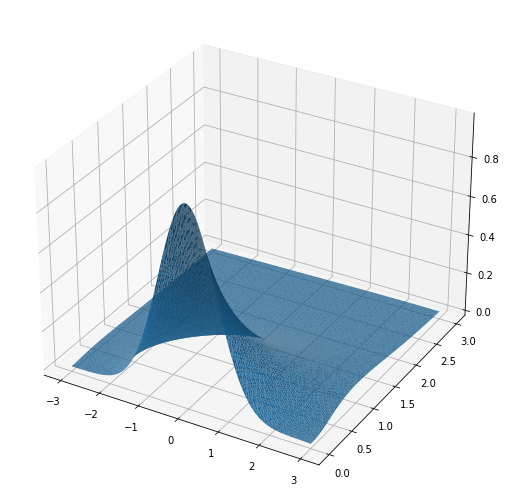

In [ ]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_trisurf(x_pinn.reshape(-1,), t_pinn.reshape(-1,), z_pinn.reshape(-1,),
                linewidth = 0.2,
                antialiased = True);
 
# show plot
plt.show()

In [ ]:
t_start = 1
t_end = 2
x_end = 3
x_num = 300
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_li = [20, 40, 60, 80]
uxx, ux, utt, ut, u = [], [], [], [], []
for t in t_li:
    uxx.append(u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ux.append(u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ut.append(u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    utt.append(u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    u.append(z_pinn[t, 1:-1])

uxx = np.asarray(uxx).reshape(-1,)
ux = np.asarray(ux).reshape(-1,)
utt = np.asarray(utt).reshape(-1,)
ut = np.asarray(ut).reshape(-1,)
u = np.asarray(u).reshape(-1,)

print(mean_squared_error(ut, uxx - u - ux, squared = False))
head, phi = Phi_u(u, ux, uxx, ut, utt)
print(head)

0.0006028489088038752
['u', 'u**2', 'u**3', 'u*ux', 'ux', 'uxx']


In [ ]:
re_tab = linear_opt_main('L-BFGS-B', 200, head, phi, 0.001, ut, 0.01)
re_tab

<function linear_re at 0x7f939ebbfa60>
<function sparse_re at 0x7f939ebbf940>
<function lasso_re at 0x7f939ebbf9d0>
<function ridge_re at 0x7f939ebbfca0>


,u,u**2,u**3,u*ux,ux,uxx,Phi RMSE,Min ACV,Max ACV,Mean ACV
0,-0.998032,0,0,0,-0.982344,0.979316,0.000228,0.000144,0.000555,0.000328
1,-0.998032,0,0,0,-0.982344,0.979316,0.000228,0.000144,0.000555,0.000328
2,-0.998059,0,0,0,-0.982293,0.979193,0.000228,0.000145,0.000557,0.000329
3,-0.998047,0,0,0,-0.982315,0.979246,0.000228,0.000144,0.000556,0.000328


In [ ]:
target = [-1, 0, 0, 0, -1, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))

0.011131125296805648
0.01113112529027441
0.011182098100373173
0.011160250539703882


In [ ]:
re_tab = linear_opt_one('L-BFGS-B', head, phi, 0.01, ut)
re_tab

<function linear_re at 0x7f939ebbfa60>
<function sparse_re at 0x7f939ebbf940>
<function lasso_re at 0x7f939ebbf9d0>
<function ridge_re at 0x7f939ebbfca0>


,u,u**2,u**3,u*ux,ux,uxx
0,-0.998652,4.856287e-02,-3.864509e-01,5.597923e-02,-0.986502,0.980702
1,-0.998652,4.857042e-02,-3.864916e-01,5.597553e-02,-0.986502,0.980702
2,-0.998247,-7.281439e-09,-1.071852e-09,-3.058433e-09,-0.981960,0.978319
3,-0.996095,-2.203400e-02,-1.634262e-02,4.694458e-02,-0.985711,0.978224


In [ ]:
target = [-1, 0, 0, 0, -1, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))

0.1609310287240648
0.16094746332585066
0.011536753126312362
0.024664399918913185


In [ ]:
x_end = 3
t_end = 3
eps = 0
gamma = [0]
layers = np.array([2,20,10,1])
x_num = 150
t_num = 150
k = 1
train_set, x_t0, u_t0 = ini_generate(x_end, t_end, x_num, t_num, 'Ex2')
test_set = test_generate(x_end, t_end, 10, 10)

In [ ]:
PINN2 = Sequentialmodel(layers, x_t0, u_t0, 
                       train_set, eps, gamma, 'Ex2')

init_params = PINN2.get_weights().numpy()

In [ ]:
results = scipy.optimize.minimize(fun = PINN2.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN2.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1e-12,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-6, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

PINN2.set_weights(results.x)

0.21499088414512194 0.15903198206838617 0.055958902076735768
0.15068215233426829 0.10739268001946843 0.043289472314799848
0.03330487871300046 0.024085497995743648 0.00921938071725681
0.028378719376443845 0.01986057354941902 0.0085181458270248232
0.026440192713311616 0.019379017063535769 0.007061175649775848
0.025225317736650692 0.018997325914891661 0.0062279918217590319
0.024372508426274038 0.018445981698438082 0.0059265267278359561
0.021993996564044122 0.016536675709949284 0.005457320854094839
0.017563159323057402 0.012249314747994129 0.0053138445750632738
0.014427843194863014 0.0088678940915624237 0.0055599491033005892
0.01371345846237236 0.0082940523712093268 0.0054194060911630336
0.013458362623199336 0.0077653450272759245 0.0056930175959234112
0.01304348482542508 0.0071451816652022548 0.0058983031602228243
0.0123532590681338 0.0064542507111721983 0.0058990083569616025
0.011412581922719343 0.0060313542431049971 0.0053812276796143454
0.009964939200279594 0.0056650730245391429 0.00429

In [ ]:
t_start = 1
t_end = 2
x_end = 3
t_num = 100
x_num = 50
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx + u*(1-u), squared = False))

0.0005612749262483316
0.0006126465806368437
0.0006276935034075417
0.0006555317447135692
0.0006934465903570892
0.0006850101158937946
0.0006218996099501714
0.0005346200499884471
0.00046299476537149886


In [ ]:
t_start = 4
t_end = 5
x_end = 3
t_num = 100
x_num = 50
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx + u*(1-u), squared = False))

0.0008498314541419366
0.0008302730367586003
0.0008325877204267895
0.0008577592318373811
0.000903754442921216
0.0009669266427757168
0.00104345023187792
0.0011301382209417978
0.0012246156178290562


In [ ]:
t_start = 0
t_end = 3
x_end = 3
x_num = 200
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

Text(0.5, 0, 'u')

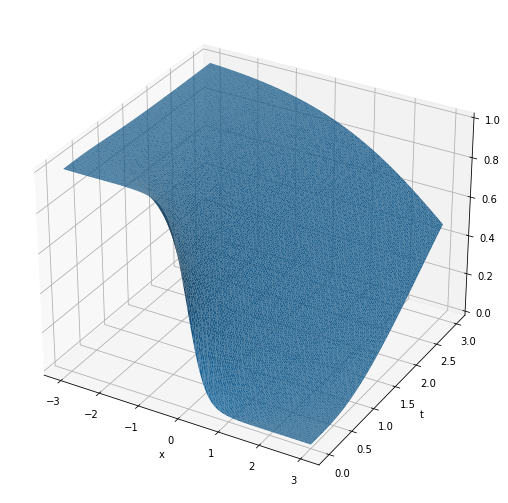

In [ ]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_trisurf(x_pinn.reshape(-1,), t_pinn.reshape(-1,), z_pinn.reshape(-1,),
                linewidth = 0.2,
                antialiased = True);
 
# show plot
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

In [ ]:
t_start = 1
t_end = 2
x_end = 3
x_num = 300
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN2, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_li = [20, 40, 60, 80]
uxx, ux, utt, ut, u = [], [], [], [], []
for t in t_li:
    uxx.append(u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ux.append(u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ut.append(u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    utt.append(u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    u.append(z_pinn[t, 1:-1])

uxx = np.asarray(uxx).reshape(-1,)
ux = np.asarray(ux).reshape(-1,)
utt = np.asarray(utt).reshape(-1,)
ut = np.asarray(ut).reshape(-1,)
u = np.asarray(u).reshape(-1,)

print(mean_squared_error(ut, uxx + u*(1-u), squared = False))
head, phi = Phi_u(u, ux, uxx, ut, utt)

0.0006089367720372146


In [ ]:
re_tab = linear_opt_main('L-BFGS-B', 200, head, phi, 0.001, ut, 0.01)
re_tab

<function linear_re at 0x7f939ebbfa60>
<function sparse_re at 0x7f939ebbf940>
<function lasso_re at 0x7f939ebbf9d0>
<function ridge_re at 0x7f939ebbfca0>


,u,u**2,u**3,u*ux,ux,uxx,Phi RMSE,Min ACV,Max ACV,Mean ACV
0,0.998077,-0.997381,0,0,0,1.006269,0.000511,0.000072,0.000247,0.000136
1,0.998077,-0.997381,0,0,0,1.006269,0.000511,0.000072,0.000247,0.000136
2,0.998075,-0.997380,0,0,0,1.006262,0.000511,0.000072,0.000247,0.000136
3,0.998076,-0.997380,0,0,0,1.006265,0.000511,0.000072,0.000247,0.000136


In [ ]:
target = [1, -1, 0, 0, 0, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))


0.0028828503048399542
0.0028828503097949767
0.002880597701346765
0.0028815350901575695


In [ ]:
re_tab = linear_opt_one('L-BFGS-B', head, phi, 0.01, ut)
re_tab

<function linear_re at 0x7f939ebbfa60>
<function sparse_re at 0x7f939ebbf940>
<function lasso_re at 0x7f939ebbf9d0>
<function ridge_re at 0x7f939ebbfca0>


,u,u**2,u**3,u*ux,ux,uxx
0,0.892502,-0.726758,-0.165380,2.775616e-01,-0.159262,0.931471
1,0.892527,-0.726820,-0.165342,2.774888e-01,-0.159221,0.931495
2,0.974674,-0.959705,-0.014603,-1.932575e-14,-0.017237,1.010918
3,0.832565,-0.559158,-0.273072,4.734461e-01,-0.260880,0.875771


In [ ]:
target = [1, -1, 0, 0, 0, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))


0.19177626389366087
0.1917290477326195
0.021964440794453383
0.31743405222075116


In [ ]:
# Example 3

x_end = 3
t_end = 3
eps = 0
gamma = [0]
layers = np.array([2,20,10,1])
x_num = 150
t_num = 150
k = 1
train_set, x_t0, u_t0 = ini_generate(x_end, t_end, x_num, t_num, 'Ex3')
test_set = test_generate(x_end, t_end, 10, 10)

In [ ]:
PINN3 = Sequentialmodel(layers, x_t0, u_t0, 
                       train_set, eps, gamma, 'Ex3')

init_params = PINN3.get_weights().numpy()

In [ ]:
results = scipy.optimize.minimize(fun = PINN3.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN3.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1e-12,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-6, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

PINN3.set_weights(results.x)

0.24395927075194634 0.1108157877141643 0.13314348303778203
0.090623020767218759 0.013662219032075455 0.0769608017351433
0.058969358215622977 0.011455329050121693 0.047514029165501286
0.017751489898325017 0.004173803112220275 0.013577686786104742
0.0098460535643988354 0.0015583644380066986 0.0082876891263921372
0.0070140824667012606 0.0011814467648822693 0.005832635701818991
0.0055605647028905587 0.0011779207798484465 0.0043826439230421118
0.0038595686921030249 0.00087626797634168124 0.0029833007157613438
0.0022069165583721547 0.00056146420563642945 0.0016454523527357253
0.0015073411872277473 0.00038012952720970465 0.0011272116600180427
0.001263304841298914 0.0002647273408724187 0.00099857750042649544
0.0010724787739715684 0.00018080929151052788 0.00089166948246104062
0.00084568596403216778 0.00012449363804930785 0.0007211923259828599
0.00057888622684281453 0.00010688409423958501 0.00047200213260322952
0.00040560203468514974 0.00010768606592247737 0.00029791596876267235
0.00037514561209

In [ ]:
t_start = 1
t_end = 2
x_end = 3
t_num = 100
x_num = 50
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u*ux, squared = False))

0.00017136429442792973
0.0001824954781801851
0.0001867515640489696
0.00018267633732720376
0.00017192279038518381
0.00015768267781698754
0.00014405800293339238
0.00013539366572854438
0.00013456827833308393


In [ ]:
t_start = 4
t_end = 5
x_end = 3
t_num = 100
x_num = 50
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_test = np.linspace(0, 100, 11)[1:-1]
for t in t_test:
    t = int(t)
    uxx=u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ux=u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0])
    ut=u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    utt=u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1]
    u=z_pinn[t, 1:-1]

    print(mean_squared_error(ut, uxx - u*ux, squared = False))

0.0018607324194917874
0.001961764983585122
0.0020537733555426683
0.0021387045216794526
0.002219246246020195
0.0022987122351415244
0.002380859730984748
0.0024696393135866974
0.0025688933271740973


In [ ]:
t_start = 0
t_end = 3
x_end = 3
x_num = 200
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

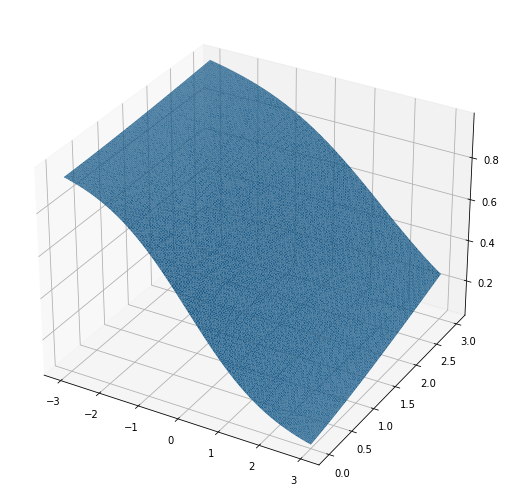

In [ ]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_trisurf(x_pinn.reshape(-1,), t_pinn.reshape(-1,), z_pinn.reshape(-1,),
                linewidth = 0.2,
                antialiased = True);
 
# show plot
plt.show()

In [ ]:
t_start = 1
t_end = 2
x_end = 3
x_num = 300
t_num = 100
z_pinn, x_pinn, t_pinn = x_y_z_generate(PINN3, x_end, t_start, t_end, x_num, t_num)

In [ ]:
t_li = [20,40, 60, 80]
uxx, ux, utt, ut, u = [], [], [], [], []
for t in t_li:
    uxx.append(u_xx(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ux.append(u_x(z_pinn, t, x_pinn[0,1] - x_pinn[0,0]))
    ut.append(u_t(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    utt.append(u_tt(z_pinn, t, t_pinn[1,0] - t_pinn[0,0])[1:-1])
    u.append(z_pinn[t, 1:-1])

uxx = np.asarray(uxx).reshape(-1,)
ux = np.asarray(ux).reshape(-1,)
utt = np.asarray(utt).reshape(-1,)
ut = np.asarray(ut).reshape(-1,)
u = np.asarray(u).reshape(-1,)

print(mean_squared_error(ut, uxx - u*ux, squared = False))
head, phi = Phi_u(u, ux, uxx, ut, utt)
print(head)

0.0001565011043447151
['u', 'u**2', 'u**3', 'u*ux', 'ux', 'uxx']


In [ ]:
re_tab = linear_opt_main('L-BFGS-B', 200, head, phi, 0.001, ut, 0.01)
re_tab

<function linear_re at 0x7f939ebbfa60>
<function sparse_re at 0x7f939ebbf940>
<function lasso_re at 0x7f939ebbf9d0>
<function ridge_re at 0x7f939ebbfca0>


,u,u**2,u**3,u*ux,ux,uxx,Phi RMSE,Min ACV,Max ACV,Mean ACV
0,0,0,0,-1.000471,0,1.000395,0.000153,0.000034,0.000074,0.000054
1,0,0,0,-1.000471,0,1.000395,0.000153,0.000034,0.000074,0.000054
2,0,0,0,-1.000469,0,1.000392,0.000153,0.000034,0.000074,0.000054
3,0,0,0,-1.000470,0,1.000393,0.000153,0.000034,0.000074,0.000054


In [ ]:
target = [0, 0, 0, -1, 0, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))


0.0002509731670397896
0.00025097316029039514
0.00024942323098003737
0.0002498769846490088


In [ ]:
re_tab = linear_opt_one('L-BFGS-B', head, phi, 0.01, ut)
re_tab

<function linear_re at 0x7f939ebbfa60>
<function sparse_re at 0x7f939ebbf940>
<function lasso_re at 0x7f939ebbf9d0>
<function ridge_re at 0x7f939ebbfca0>


,u,u**2,u**3,u*ux,ux,uxx
0,0.000063,-1.454882e-02,0.014060,-1.019879,0.000403,0.999682
1,0.000245,-1.473698e-02,0.014072,-1.019594,0.000484,0.999514
2,-0.000077,-5.297164e-09,-0.000004,-0.943838,-0.028542,0.961905
3,-0.028340,8.664295e-02,-0.057889,-0.832286,-0.082548,0.935895


In [ ]:
target = [0, 0, 0, -1, 0, 1]
for i in range(len(re_tab)):
    print(mean_squared_error(re_tab.iloc[i,:6], target, squared=False))


0.011581574323292074
0.011544339408346527
0.030055661348135757
0.09193561483272146
